In [1]:
from model import UNET
from util import *
import tensorflow as tf
import numpy as np


import os
import tarfile

In [2]:
dataPath = os.path.join(".","Data","Images")
maskPath = os.path.join(".","Data","Segmentation")
dataType = "*.png"

SEED = 42
DATA_SPLIT = 1

OPTIMIZER = "adam"
LOSS = "binary_crossentropy"
METRICS = ["accuracy"]

In [3]:
if not os.path.isdir(dataPath) or not os.path.isdir(maskPath):
    #untar the data if it hasnt been
    print("UNZIPPING DATA")
    with tarfile.open(os.path.join(".","Data","data.tar.gz")) as file:
        file.extractall(os.path.join(".","Data"))


Metal device set to: Apple M1 Pro


2022-03-01 18:03:22.506370: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-01 18:03:22.506516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-01 18:03:22.581840: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-01 18:03:22.582094: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


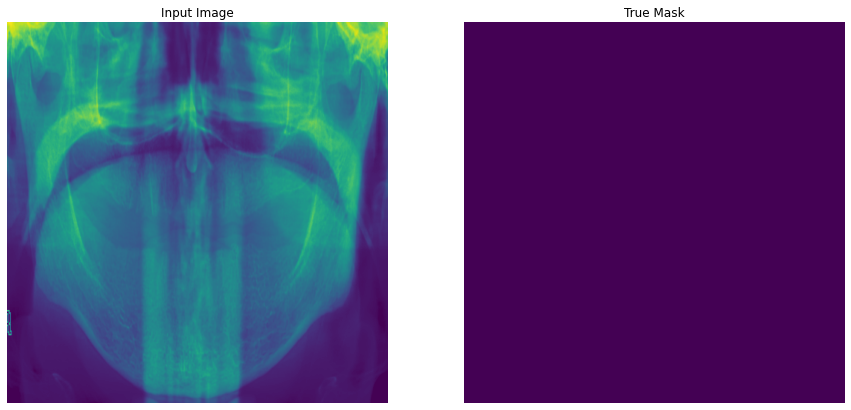

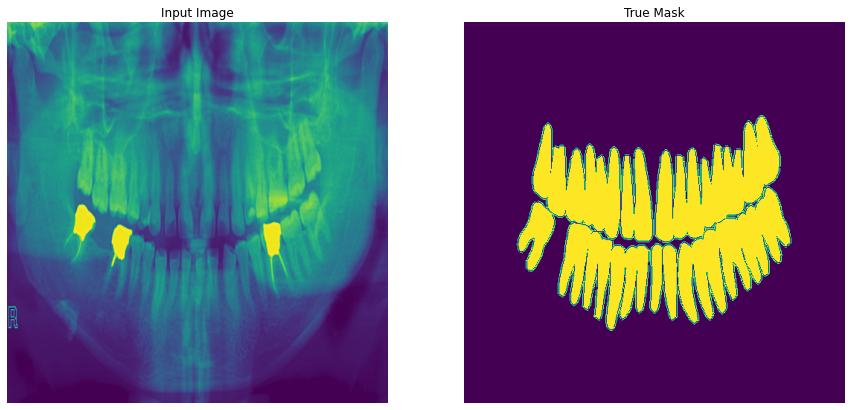

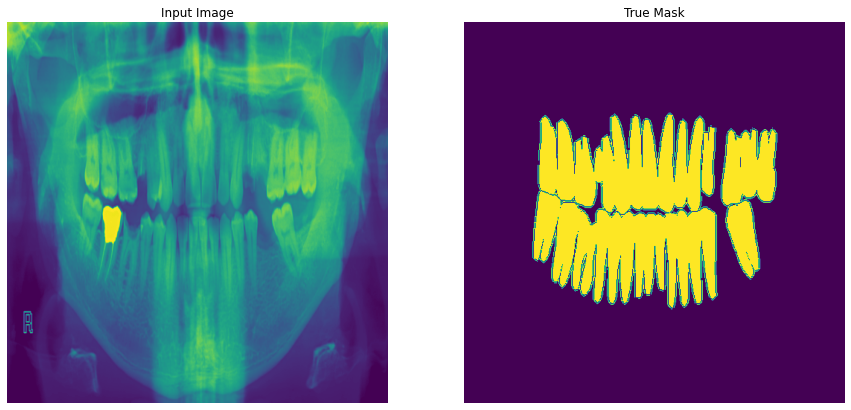

In [4]:
# LOAD DATASET AS TF DATASET
dataset = generate_dataset(dataPath, dataType, seed=SEED, img_shape = [512,512])
for element in dataset.take(3):
    image_shape = element["image"].numpy().shape
    display_mask_image([element["image"],element["mask"]])
    
dataset = [(element["image"],element["mask"]) for element in dataset]

#for some reason, passing the dataset directly into the model is giving me all sorts of trouble, let us instead
xtrain = np.array([x[0] for x in dataset])
ytrain = np.array([x[1] for x in dataset])

In [5]:
print("IMAGE SHAPE -> {shp}".format(shp=(image_shape)))
model = UNET(input_shape = image_shape)
model.summary()
model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

IMAGE SHAPE -> (512, 512, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
Down1A (Conv2D)                 (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
Down1B (Dropout)                (None, 512, 512, 32) 0           Down1A[0][0]                     
__________________________________________________________________________________________________
Down1C (Conv2D)                 (None, 512, 512, 32) 9248        Down1B[0][0]                     
_________________________________________________________________

In [6]:
history = model.fit(xtrain,ytrain,validation_split = 0.1, batch_size=16,epochs=120,verbose=1)
model.save('./trained')

Epoch 1/120


2022-03-01 18:03:24.562775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.5319 - accuracy: 0.7591

2022-03-01 18:03:49.415368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 26s 4s/step - loss: 0.5319 - accuracy: 0.7591 - val_loss: 24.8687 - val_accuracy: 0.2905
Epoch 2/120
7/7 [==============================] - 26s 4s/step - loss: 0.3509 - accuracy: 0.8441 - val_loss: 318.9688 - val_accuracy: 0.3243
Epoch 3/120
7/7 [==============================] - 26s 4s/step - loss: 0.2374 - accuracy: 0.8987 - val_loss: 6.4466 - val_accuracy: 0.6127
Epoch 4/120
7/7 [==============================] - 25s 4s/step - loss: 0.1932 - accuracy: 0.9179 - val_loss: 7.6514 - val_accuracy: 0.7935
Epoch 5/120
7/7 [==============================] - 25s 4s/step - loss: 0.1702 - accuracy: 0.9281 - val_loss: 4.6491 - val_accuracy: 0.7722
Epoch 6/120
7/7 [==============================] - 26s 4s/step - loss: 0.1633 - accuracy: 0.9329 - val_loss: 5.1663 - val_accuracy: 0.7714
Epoch 7/120
7/7 [==============================] - 25s 4s/step - loss: 0.1474 - accuracy: 0.9391 - val_loss: 0.8528 - val_accuracy: 0.7743
Epoch 8/120
7/7 [===================

7/7 [==============================] - 26s 4s/step - loss: 0.0574 - accuracy: 0.9726 - val_loss: 0.1890 - val_accuracy: 0.9364
Epoch 60/120
7/7 [==============================] - 25s 4s/step - loss: 0.0559 - accuracy: 0.9731 - val_loss: 0.2003 - val_accuracy: 0.9393
Epoch 61/120
7/7 [==============================] - 25s 4s/step - loss: 0.0564 - accuracy: 0.9728 - val_loss: 0.1954 - val_accuracy: 0.9390
Epoch 62/120
7/7 [==============================] - 25s 4s/step - loss: 0.0554 - accuracy: 0.9731 - val_loss: 0.1646 - val_accuracy: 0.9444
Epoch 63/120
7/7 [==============================] - 25s 4s/step - loss: 0.0556 - accuracy: 0.9730 - val_loss: 0.1596 - val_accuracy: 0.9446
Epoch 64/120
7/7 [==============================] - 25s 4s/step - loss: 0.0540 - accuracy: 0.9735 - val_loss: 0.1760 - val_accuracy: 0.9426
Epoch 65/120
7/7 [==============================] - 25s 4s/step - loss: 0.0530 - accuracy: 0.9736 - val_loss: 0.1659 - val_accuracy: 0.9433
Epoch 66/120
7/7 [===============

7/7 [==============================] - 26s 4s/step - loss: 0.0384 - accuracy: 0.9812 - val_loss: 0.1704 - val_accuracy: 0.9523
Epoch 118/120
7/7 [==============================] - 25s 4s/step - loss: 0.0396 - accuracy: 0.9805 - val_loss: 0.1685 - val_accuracy: 0.9548
Epoch 119/120
7/7 [==============================] - 26s 4s/step - loss: 0.0378 - accuracy: 0.9817 - val_loss: 0.1597 - val_accuracy: 0.9559
Epoch 120/120
7/7 [==============================] - 26s 4s/step - loss: 0.0372 - accuracy: 0.9821 - val_loss: 0.1603 - val_accuracy: 0.9547


2022-03-01 18:54:46.683942: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./trained/assets


In [7]:
train_predictions = model.predict(xtrain[0:3])

2022-03-01 18:54:48.532300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


# Lets view results after training

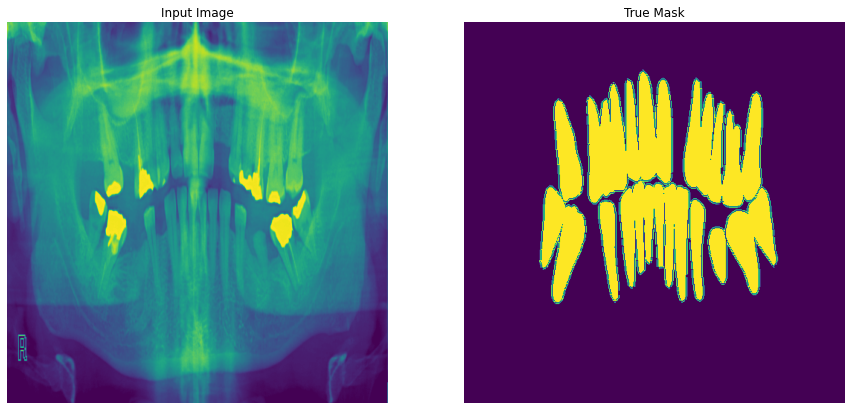

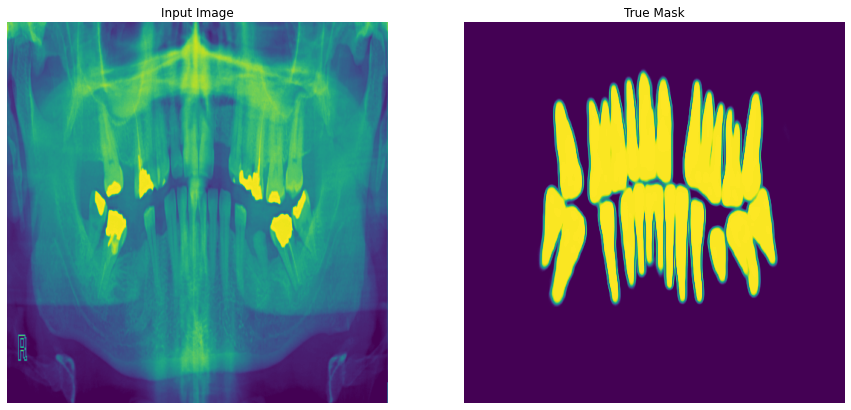

In [8]:
#TRAINING
display_mask_image([xtrain[0],ytrain[0]])
display_mask_image([xtrain[0],train_predictions[0]])

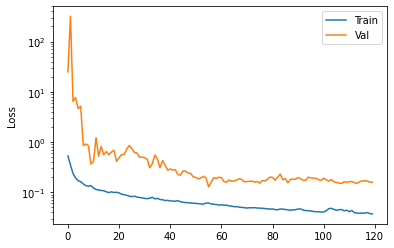

In [9]:
plt.semilogy(history.history["loss"],label="Train")
plt.semilogy(history.history["val_loss"],label="Val")
plt.ylabel("Loss")
plt.legend()

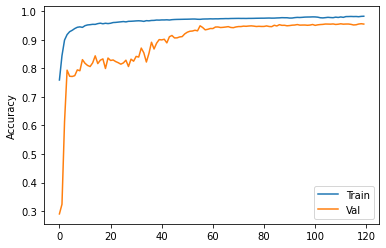

In [10]:
plt.plot(history.history["accuracy"],label="Train")
plt.plot(history.history["val_accuracy"],label="Val")
plt.ylabel("Accuracy")
plt.legend()